<a href="https://colab.research.google.com/github/chrisluedtke/chi-array-of-things/blob/master/Intro-to-Chicago-Array-of-Things.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## An Exploration of Chicago's Array of Things API (via python client)
Array of Things has expanded in Chicago to include more than 100 continuous sensors across the city.

**Resources**
* [Home Page](https://arrayofthings.github.io)
* [python client](https://github.com/UrbanCCD-UChicago/aot-client-py)
* [API documentation](https://arrayofthings.docs.apiary.io)

**TODOs**
  * more efficient queries to get a spread of data
  * dropdown sensor type, generate animation over the day, for temperature

In [2]:
 # !pip install aot-client

In [72]:
from aot_client import AotClient

client = AotClient()

# What are the methods/properties of the client?
[_ for _ in dir(client) if not _.startswith('_')]

['get_node_details',
 'get_project_details',
 'get_sensor_details',
 'list_metrics',
 'list_nodes',
 'list_observations',
 'list_projects',
 'list_sensors']

It appears results will be paginated and we can also pass a filter. From the docs website I see that users may pass a timestamp filter in ISO 8601 format. Let's get measurements from the past 15 minutes.

In [267]:
import datetime

import pandas as pd
from aot_client import AotClient
from aot_client import F


def time_x_mins_ago(minutes:int):
    '''Get formatted time to pass to API filter, relative to current time
    '''
    t = (datetime.datetime.now() - 
         datetime.timedelta(minutes=minutes) + 
         datetime.timedelta(hours=5))  # convert timezone from central
    t = t.isoformat()
    
    return t[0:19]


def unpack_response(response, page_limit=1000):
    try:
        pages = []
        for i, page in enumerate(response):
            if i + 1 > page_limit:
                break
            pages.extend(page.data)
    except HTTPError as e:
        print(e)    
    finally:
        return pages


def process_observations(obs_df):
    # extract lat/lon to columns
    obs_df['coords'] = obs_df['location'].apply(
        lambda x: x['geometry']['coordinates'])
    obs_df[['lon', 'lat']] = pd.DataFrame(
        obs_df['coords'].tolist(), columns=['lon', 'lat'])
    obs_df = obs_df.drop(columns=['coords'])
    
    # fix positive lon values
    mask = obs_df['lon'] > 0
    if sum(mask) > 0:
        print(f'fixed {sum(mask)} rows with positive lon value')
        obs_df.loc[mask, 'lon'] = obs_df.loc[mask, 'lon'] * -1

    # remove lat/lon values at 0
    mask = (obs_df['lon'] != 0) & (obs_df['lat'] != 0)
    if len(obs_df) - sum(mask) > 0:
        print(f'removed {len(obs_df) - sum(mask)} rows with lat/lon at 0')
        obs_df = obs_df.loc[mask]

    # remove lat values less than 40 degrees
    mask = (obs_df['lat'] > 40)
    if len(obs_df) - sum(mask) > 0:
        print(f'removed {len(obs_df) - sum(mask)} '
              'rows with lat/lon outside Chicago region')
        obs_df = obs_df.loc[mask]
    
    return obs_df

In [291]:
client = AotClient()

# create filter
f = F()
# f &= ('timestamp', 'ge', time_x_mins_ago(5))
f &= ('sensor', 'image.image_detector.person_total')
# f &= ('sensor', 'image.image_detector.car_total')
# f &= ('sensor', 'metsense.tsys01.temperature')

response = client.list_observations(filters=f)

pages = unpack_response(response, page_limit=1)
print(len(pages))
obs_df = pd.DataFrame(pages)

200


In [292]:
f.filters

{'sensor': [('image.image_detector.person_total',)]}

In [293]:
response.current_link

'https://api-of-things.plenar.io/api/observations?order=desc%3Atimestamp&page=1&sensor=image.image_detector.person_total&size=200'

In [294]:
obs_df = process_observations(obs_df)
print(f"shape: {obs_df.shape}")
obs_df.head()

removed 2 rows with lat/lon at 0
shape: (198, 8)


,location,node_vsn,sensor_path,timestamp,uom,value,lon,lat
0,"{'type': 'Feature', 'geometry': {'type': 'Poin...",12D,image.image_detector.person_total,2019-05-17T23:15:46,counts,0.0,-88.062771,41.922183
1,"{'type': 'Feature', 'geometry': {'type': 'Poin...",12D,image.image_detector.person_total,2019-05-17T23:10:45,counts,0.0,-88.062771,41.922183
2,"{'type': 'Feature', 'geometry': {'type': 'Poin...",12D,image.image_detector.person_total,2019-05-17T23:10:42,counts,0.0,-88.062771,41.922183
3,"{'type': 'Feature', 'geometry': {'type': 'Poin...",12D,image.image_detector.person_total,2019-05-17T23:05:45,counts,0.0,-88.062771,41.922183
4,"{'type': 'Feature', 'geometry': {'type': 'Poin...",11F,image.image_detector.person_total,2019-05-17T23:05:44,counts,0.0,-88.062771,41.922183


In [307]:
import folium
import folium.plugins

def map(df):
    m = folium.Map(location=[df['lat'].mean(), 
                             df['lon'].mean()],
                   tiles='CartoDB dark_matter',
                   zoom_start=12)

    for i, r in df.iterrows():
        folium.CircleMarker(
            location=(r['lat'], r['lon']),              
    #         radius=3,
    #         color=r['color'],
    #         weight=0.5,
            tooltip=f"{r['timestamp']}<br>{r['value']} {r['uom']}",
#             popup=folium.Popup(f"{r['value']} {r['uom']}", max_width=500),
            fill=True
        ).add_to(m)

    folium.plugins.Fullscreen(
        position='topright',
        force_separate_button=True
    ).add_to(m)

    return m

In [308]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

sensors = client.list_sensors()
sensors_df = pd.DataFrame(sensors.data)
sensors_df.head()

@interact
def choose_sensor(sensor=sensors_df['path'].unique()):
    client = AotClient()
    f = F(('sensor', sensor))

    response = client.list_observations(filters=f)
    pages = unpack_response(response, page_limit=1)
    obs_df = pd.DataFrame(pages)
    obs_df = process_observations(obs_df)
    
    return map(obs_df.drop_duplicates(['lon', 'lat']))

interactive(children=(Dropdown(description='sensor', options=('alphasense.opc_n2.bins', 'alphasense.opc_n2.fw', 'alphasense.opc_n2.pm1', 'alphasense.opc_n2.pm10', 'alphasense.opc_n2.pm2_5', 'alphasense.opc_n2.sample_flow_rate', 'alphasense.opc_n2.sampling_period', 'audio.microphone.octave_10_intensity', 'audio.microphone.octave_1_intensity', 'audio.microphone.octave_2_intensity', 'audio.microphone.octave_3_intensity', 'audio.microphone.octave_4_intensity', 'audio.microphone.octave_5_intensity', 'audio.microphone.octave_6_intensity', 'audio.microphone.octave_7_intensity', 'audio.microphone.octave_8_intensity', 'audio.microphone.octave_9_intensity', 'audio.microphone.octave_total_intensity', 'chemsense.at0.temperature', 'chemsense.at1.temperature', 'chemsense.at2.temperature', 'chemsense.at3.temperature', 'chemsense.chemsense.id', 'chemsense.co.concentration', 'chemsense.h2s.concentration', 'chemsense.lps25h.pressure', 'chemsense.lps25h.temperature', 'chemsense.no2.concentration', 'chemsense.o3.concentration', 'chemsense.oxidizing_gases.concentration', 'chemsense.reducing_gases.concentration', 'chemsense.sht25.humidity', 'chemsense.sht25.temperature', 'chemsense.si1145.ir_intensity', 'chemsense.si1145.uv_intensity', 'chemsense.si1145.visible_light_intensity', 'chemsense.so2.concentration', 'ep.device.bcam', 'ep.device.coresense', 'ep.device.lan', 'ep.device.mic', 'ep.device.modem', 'ep.device.samba', 'ep.device.tcam', 'ep.device.wagman', 'ep.device.wwan', 'ep.disk_size.boot', 'ep.disk_size.root', 'ep.disk_size.rw', 'ep.disk_used.boot', 'ep.disk_used.root', 'ep.disk_used.rw', 'ep.disk_used_ratio.boot', 'ep.disk_used_ratio.root', 'ep.disk_used_ratio.rw', 'ep.loadavg.loadavg1', 'ep.loadavg.loadavg15', 'ep.loadavg.loadavg5', 'ep.media.media', 'ep.mem.free', 'ep.mem.free_ratio', 'ep.mem.total', 'ep.modem.dbm', 'ep.net_rx.lan', 'ep.net_rx.wwan', 'ep.net_tx.lan', 'ep.net_tx.wwan', 'ep.ping.beehive', 'ep.ping.ep', 'ep.ping.nc', 'ep.plugins.active', 'ep.plugins.enabled', 'ep.service_active.coresense', 'ep.service_active.rabbitmq', 'ep.time.time', 'ep.uptime.uptime', 'image.image_detector.car_total', 'image.image_detector.person_total', 'lightsense.apds_9006_020.intensity', 'lightsense.hih6130.humidity', 'lightsense.hih6130.temperature', 'lightsense.hmc5883l.magnetic_field_x', 'lightsense.hmc5883l.magnetic_field_y', 'lightsense.hmc5883l.magnetic_field_z', 'lightsense.ml8511.intensity', 'lightsense.mlx75305.intensity', 'lightsense.tmp421.temperature', 'lightsense.tsl250rd.intensity', 'lightsense.tsl260rd.intensity', 'metsense.bmp180.pressure', 'metsense.bmp180.temperature', 'metsense.hih4030.humidity', 'metsense.htu21d.humidity', 'metsense.htu21d.temperature', 'metsense.metsense.id', 'metsense.mma8452q.acceleration_x', 'metsense.mma8452q.acceleration_y', 'metsense.mma8452q.acceleration_z', 'metsense.pr103j2.temperature', 'metsense.spv1840lr5h_b.intensity', 'metsense.tmp112.temperature', 'metsense.tsl250rd.intensity', 'metsense.tsys01.temperature', 'nc.device.bcam', 'nc.device.coresense', 'nc.device.lan', 'nc.device.mic', 'nc.device.modem', 'nc.device.samba', 'nc.device.tcam', 'nc.device.wagman', 'nc.device.wwan', 'nc.disk_size.boot', 'nc.disk_size.root', 'nc.disk_size.rw', 'nc.disk_used.boot', 'nc.disk_used.root', 'nc.disk_used.rw', 'nc.disk_used_ratio.boot', 'nc.disk_used_ratio.root', 'nc.disk_used_ratio.rw', 'nc.loadavg.loadavg1', 'nc.loadavg.loadavg15', 'nc.loadavg.loadavg5', 'nc.media.media', 'nc.mem.free', 'nc.mem.free_ratio', 'nc.mem.total', 'nc.modem.dbm', 'nc.net_rx.lan', 'nc.net_rx.wwan', 'nc.net_tx.lan', 'nc.net_tx.wwan', 'nc.ping.beehive', 'nc.ping.ep', 'nc.ping.nc', 'nc.plugins.active', 'nc.plugins.enabled', 'nc.service_active.coresense', 'nc.service_active.rabbitmq', 'nc.time.time', 'nc.uptime.uptime', 'plantower.pms7003.10um_particle', 'plantower.pms7003.1um_particle', 'plantower.pms7003.2_5um_particle', 'plantower.pms7003.5um_particle', 'plantower.pms7003.pm10_atm', 'plantower.pms7003.pm10_cf', 'plantower.pms7003.pm1_atm', '

Things I notice:
* multiple temperature, pressure, humidity measures - are they comparable within the same node?
* accelerometers are an interesting choice. I wonder how that data can be used.
* does every node contain the same sensors?

We already stored sensor observations in `obs_df`, but we still don't have context around the data. For that we must pull details about the sensors themselves.

### Interesting Sensors
https://github.com/waggle-sensor/sensors/blob/master/sensors/datasheets/en-d6t.pdf

What's going on with all those **temperature** measures?

In [0]:
# sort to get most recent data first
df = df.sort_values('timestamp', ascending=False)

# drop duplicates to keep only the most recent value of each measurement
df = df.drop_duplicates(['node_vsn', 'sensor_path'])

temps_df = df.loc[
    (df['parameter'] == 'temperature') & 
    (df['uom'] == 'C')
]
temps_df.groupby('node_vsn')['value'].apply(lambda x: x.unique())

node_vsn
004    [46.12, 7.35, 15.75, 4.4, 8.15, 7.81, 7.54, 8....
01C    [17.12, 23.07, 7.9, 7.39, 6.65, 6.62, 10.03, 6...
01F    [6.99, 14.0, 6.58, 6.94, 6.8, 9.57, 6.98, 12.6...
020    [6.55, 6.5, 5.83, -0.5, 14.12, 10.03, 6.37, 16.0]
02A    [13.0, 6.76, 5.1, 6.39, 7.42, -50.25, 6.62, 6....
02D    [6.43, 8.29, 6.1, 7.61, 18.92, 6.74, 7.0, 6.8,...
030    [6.35, 125.01, -254.0, -0.06, 214.75, 241.0, 1...
04C    [7.06, 8.14, -4.63, 15.18, 7.25, -53.87, 7.24,...
04D                                        [6.1, -84.84]
051           [6.94, 28.66, 12.44, 6.88, 9.3, 6.2, 6.71]
052                                               [7.45]
053          [17.42, 7.85, 7.03, 6.8, 6.87, 14.81, 6.88]
056            [13.0, 14.99, 9.0, 5.86, 5.81, 4.6, 5.62]
06D    [8.81, 9.13, 8.11, 9.15, 8.34, 9.16, 9.74, 10....
071         [6.58, 6.94, 6.9, -5.83, 34.93, 15.19, 30.9]
073    [6.3, 214.75, -254.0, 9.8, 8.08, 7.2, 7.75, 12...
079    [6.3, -254.0, 214.75, 125.01, -0.06, 128.86, 2...
07F    [214.75, -254.0

Interesting. These temperatures are quite different from one another, even within the same node.

How about CO levels?

In [0]:
co_conc_df = df.loc[df['sensor'] == 'co']

co_conc_df

,node_vsn,sensor_path,timestamp,value,lon,lat,parameter,sensor,uom
584,08F,chemsense.co.concentration,2019-01-08T22:20:43,0.07933,-87.665948,41.961622,concentration,co,ppm
1435,02A,chemsense.co.concentration,2019-01-08T22:20:43,-0.38364,-87.575350,41.722457,concentration,co,ppm
3527,09C,chemsense.co.concentration,2019-01-08T22:20:35,-0.35367,-87.627864,41.884688,concentration,co,ppm
6459,088,chemsense.co.concentration,2019-01-08T22:20:34,0.09035,-87.666720,41.965256,concentration,co,ppm
7310,004,chemsense.co.concentration,2019-01-08T22:20:34,-0.59134,-87.627678,41.878377,concentration,co,ppm
9937,01C,chemsense.co.concentration,2019-01-08T22:20:32,-0.46646,-87.712990,41.751238,concentration,co,ppm
11369,08C,chemsense.co.concentration,2019-01-08T22:20:32,-0.31108,-87.687703,41.924903,concentration,co,ppm
12183,08B,chemsense.co.concentration,2019-01-08T22:20:31,-0.34345,-87.598713,41.788608,concentration,co,ppm
14653,01F,chemsense.co.concentration,2019-01-08T22:20:28,-0.07006,-87.624179,41.736314,concentration,co,ppm
15576,096,chemsense.co.concentration,2019-01-08T22:20:27,-0.36994,-87.536509,41.713867,concentration,co,ppm


I wonder how there can be negative ppm values. Let's plot it anyway.

In [0]:
# create a normalized set of values that will be easier scale
co_conc_df['value_norm'] = (
    (co_conc_df['value'] - min(co_conc_df['value'])) / 
    (max(co_conc_df['value']) - min(co_conc_df['value']))
) * 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


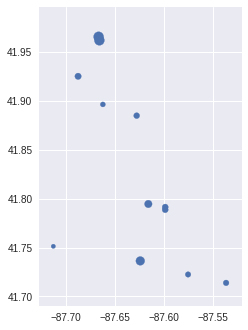

In [0]:
plt.scatter(co_conc_df['lon'], co_conc_df['lat'], s=co_conc_df['value_norm'])
plt.axes().set_aspect('equal')
plt.show()